# Installs and Imports

In [2]:
!pip install --upgrade nltk

In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import re
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import transforms
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import random
from textwrap import wrap
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms as T
from torchvision import models
import torch.nn.functional as F
from nltk.translate.meteor_score import meteor_score

In [5]:
# to make sure the results are reproducible
torch.manual_seed(0)
random.seed(42)


# Dataset

In [6]:
df=pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")


In [7]:
def read_image(path,img_size=224):
      transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()])
      img = Image.open(path).convert('RGB')
      img = transform(img)
      return img.permute(1, 2, 0).numpy()

In [8]:
def display_image(temp_df):
    temp_df=temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(5):  # Display 5 images
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # Load and display the image
        image_path = f"/kaggle/input/flickr8kimagescaptions/flickr8k/images/{temp_df.image[i]}"
        image = read_image(image_path)
        plt.imshow(image)
        
        # Display the caption
        caption = "\n".join(wrap(temp_df.caption[i], 20))  # Wrap text for better display
        plt.title(caption)
        plt.axis("off")  # Turn off axis
    
    plt.show()

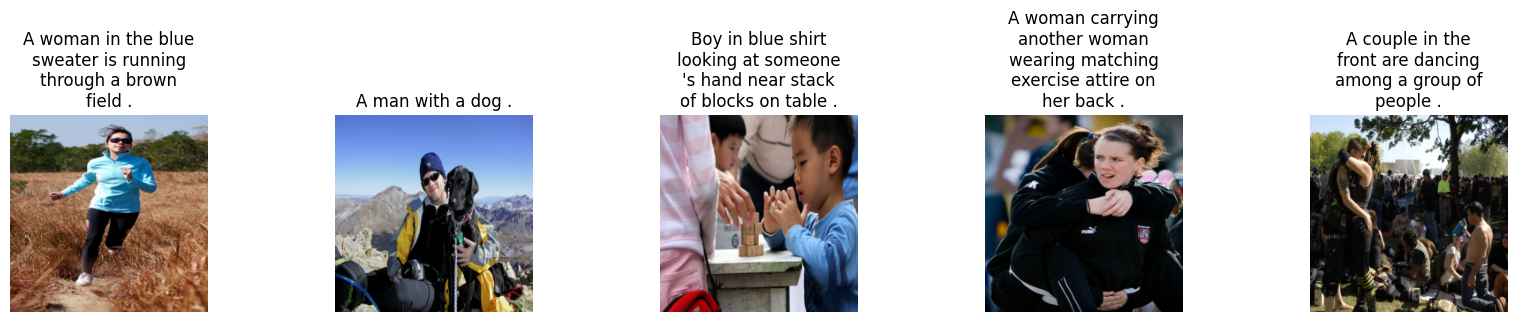

In [9]:
display_image(df.sample(5))

# Data Preprocessing

In [10]:
image_captions = defaultdict(list)
for idx, row in df.iterrows():
    image_captions[row['image']].append(row['caption'])


In [11]:
def tokenize(text):
    # Convert text to lowercase
    text = text.lower()
    # Use regular expressions to extract words (alphanumeric characters)
    tokens = re.findall(r'\w+', text)
    return tokens

In [12]:
all_captions = []
for captions in image_captions.values():
    all_captions.extend(captions)

In [13]:
all_words = []
for caption in all_captions:
    tokens = tokenize(caption)
    all_words.extend(tokens)

In [14]:
all_words[0:10]

['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']

In [15]:
all_captions[0:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [16]:
word_counts = Counter(all_words)
word_counts["girl"]

3328

In [17]:
special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
# Create mappings from words to indices and vice versa
word2idx = {token: idx for idx, token in enumerate(special_tokens)}
idx2word = {idx: token for idx, token in enumerate(special_tokens)}

In [18]:
word2idx

{'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}

In [19]:
idx2word

{0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>'}

In [20]:
vocab_size = 10000 # we have set it as the max limit inluding the special tokens
most_common = word_counts.most_common(vocab_size - len(special_tokens))

In [21]:
start_token_id=1
end_token_id=2

In [22]:
most_common[0:10]

[('a', 62992),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723)]

In [23]:
len(most_common)

8488

In [24]:
# we are starting after the length of start tokens
for idx, (word, _) in enumerate(most_common, start=len(special_tokens)):
    word2idx[word] = idx
    idx2word[idx] = word

In [25]:
word2idx["a"]

4

In [26]:
captions_seqs = {}
max_length = 0  # Keep track of the maximum caption length
for img_name, captions in image_captions.items():
    seqs = []
    for caption in captions:
        # Tokenize the caption and add <start> and <end> tokens
        tokens = ['<start>'] + tokenize(caption) + ['<end>']
        # Convert tokens to indices, use <unk> index if word not in vocabulary
        seq = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
        seqs.append(seq)
        # Update the maximum caption length
        max_length = max(max_length, len(seq))
    captions_seqs[img_name] = seqs

In [27]:
# so now we have a dictionary with image as key and indices of words in captions as keys so the values is a list of lists
captions_seqs["1000268201_693b08cb0e.jpg"]

[[1, 4, 44, 5, 4, 91, 173, 8, 120, 52, 4, 394, 13, 395, 5, 29, 5156, 671, 2],
 [1, 4, 20, 317, 65, 4, 197, 118, 2],
 [1, 4, 41, 20, 120, 65, 4, 197, 2438, 2],
 [1, 4, 41, 20, 120, 6, 395, 21, 61, 2438, 2],
 [1, 4, 41, 20, 5, 4, 91, 173, 317, 65, 4, 197, 2982, 2]]

# Image Transformation for Preprocessing

In [28]:
transform = T.Compose([
    T.Resize((224, 224)),  # VGG16 expects 224x224 input size
    T.ToTensor(),  # Convert PIL image to tensor
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    )
])

# Dataloader setup

In [29]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, image_ids, captions_seqs, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            image_ids (list): List of image filenames.
            captions_seqs (dict): Dictionary mapping image filenames to sequences of word indices.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.captions = []
        # Prepare the list of image and caption pairs
        for img_id in image_ids:
            captions = captions_seqs[img_id]
            for caption_seq in captions:
                self.images.append(img_id)
                self.captions.append(caption_seq)
    def __len__(self):
        # Return the total number of samples
        return len(self.images)
    def __getitem__(self, idx):
        # Get the image filename and caption sequence at the given index
        img_id = self.images[idx]
        caption_seq = self.captions[idx]
        # Load the image from the directory
        img_path = os.path.join(self.image_dir, img_id)
        image = Image.open(img_path).convert('RGB')

        # Apply the transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert the caption sequence to a tensor
        caption_seq = torch.tensor(caption_seq)
        return image, caption_seq


In [30]:
def collate_fn(data):
    """
    Creates mini-batch tensors from the list of tuples (image, caption).
    We sort the captions by length to use pack_padded_sequence.
    """
    # Sort data by caption length in descending order
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Stack images into a tensor of shape (batch_size, 3, H, W)
    images = torch.stack(images, 0)
    # Get the lengths of each caption
    lengths = [len(cap) for cap in captions]
    # Create a tensor to hold the padded captions
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        # Copy the caption into the targets tensor
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [31]:
image_dir = '/kaggle/input/flickr8kimagescaptions/flickr8k/images'
image_names = list(image_captions.keys())

In [32]:
train_images, temp_images = train_test_split(image_names, test_size=0.3, random_state=22)

In [33]:

val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=12)


In [34]:
train_dataset = Flickr8kDataset(image_dir, train_images, captions_seqs, transform)
val_dataset   = Flickr8kDataset(image_dir, val_images, captions_seqs, transform)
test_dataset  = Flickr8kDataset(image_dir, test_images, captions_seqs, transform)

In [35]:
batch_size = 32  # Define the batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Model

## Encoder

In [36]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        
        # Load the pretrained VGG16 model
        vgg = models.vgg16(pretrained=True)
        
        # Extract layers up to the 4th convolutional block (before max pooling)
        self.features = nn.Sequential(*list(vgg.features.children())[:23])  # Layer index 23 is before the 4th max pool

    def forward(self, images):
        """
        Forward pass for the encoder.

        Args:
            images (torch.Tensor): Batch of input images of shape (batch_size, 3, height, width).

        Returns:
            features (torch.Tensor): Encoded image features of shape (batch_size, 196, 512).
        """
        # Extract convolutional features
        features = self.features(images)  # Shape: (batch_size, 512, 14, 14)

        # Reshape features to (batch_size, 196, 512)
        batch_size, channels, height, width = features.shape
        features = features.permute(0, 2, 3, 1).view(batch_size, -1, channels)  # Shape: (batch_size, 196, 512)

        return features

## Bahdanau Attention

In [37]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,features_dim)
        
        return alpha,attention_weights
        

## Decoder

In [38]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        # captions which are embedded 
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        # the average of the anotations are sent via a fully connected neural network for each cell and hidden
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        # captions will be of the form (batch_size,len_of_captions)
        # features or annotations will be of the form (num_of_features,feature_dim)
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0) 
        num_features = features.size(1) 
         
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device) 
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device) 
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    def generate_caption(self,features,max_len=20):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(word2idx['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if idx2word[predicted_word_idx.item()] == "<end>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [idx2word[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

## Encoder-Decoder Model

In [39]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Hyperparameters

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
epochs=10
# Hyperparameters
embed_size=256
attention_dim=256
encoder_dim=512
decoder_dim=512
learning_rate = 3e-4

Using device: cuda


In [41]:
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]  


## Loss Criteria and Optimizers

In [42]:
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

# Training

In [44]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Epoch: 1 Training batch: 100 loss: 4.84924
Epoch: 1 Training batch: 200 loss: 4.54669
Epoch: 1 Training batch: 300 loss: 4.31858
Epoch: 1 Training batch: 400 loss: 4.48858
Epoch: 1 Training batch: 500 loss: 4.12858
Epoch: 1 Training batch: 600 loss: 4.06728
Epoch: 1 Training batch: 700 loss: 3.88758
Epoch: 1 Training batch: 800 loss: 3.57046
Epoch 1:
Average Training Loss: 4.34629
Validation Loss: 3.77041
METEOR Score: 0.17804


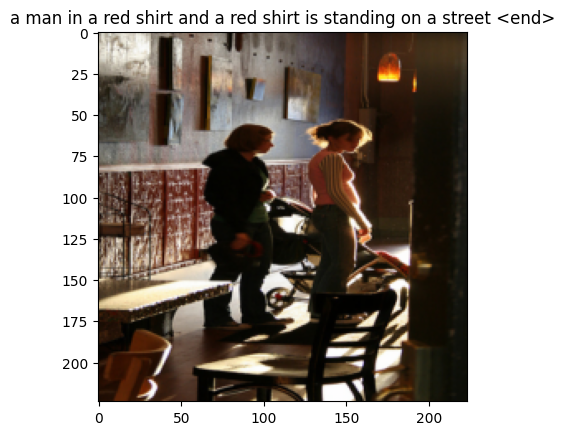

Epoch: 2 Training batch: 100 loss: 3.54784
Epoch: 2 Training batch: 200 loss: 3.64145
Epoch: 2 Training batch: 300 loss: 3.39773
Epoch: 2 Training batch: 400 loss: 3.60432
Epoch: 2 Training batch: 500 loss: 3.58604
Epoch: 2 Training batch: 600 loss: 3.56183
Epoch: 2 Training batch: 700 loss: 3.34246
Epoch: 2 Training batch: 800 loss: 3.32497
Epoch 2:
Average Training Loss: 3.52331
Validation Loss: 3.45215
METEOR Score: 0.18329


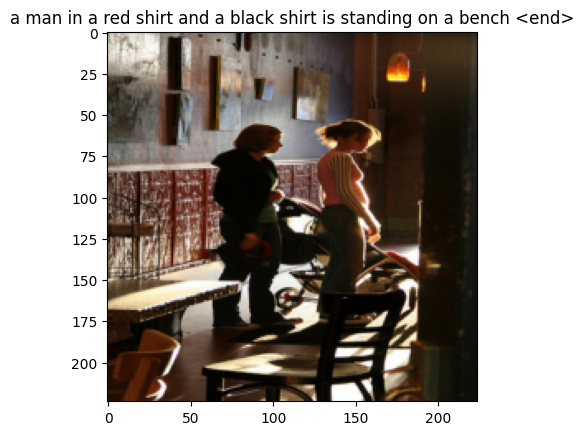

Epoch: 3 Training batch: 100 loss: 3.33754
Epoch: 3 Training batch: 200 loss: 3.07680
Epoch: 3 Training batch: 300 loss: 3.26848
Epoch: 3 Training batch: 400 loss: 3.53284
Epoch: 3 Training batch: 500 loss: 2.97046
Epoch: 3 Training batch: 600 loss: 2.91259
Epoch: 3 Training batch: 700 loss: 3.24814
Epoch: 3 Training batch: 800 loss: 2.91353
Epoch 3:
Average Training Loss: 3.19739
Validation Loss: 3.29729
METEOR Score: 0.20141


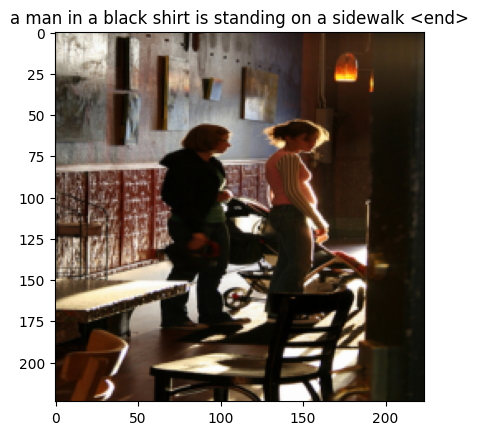

Epoch: 4 Training batch: 100 loss: 3.25011
Epoch: 4 Training batch: 200 loss: 2.76295
Epoch: 4 Training batch: 300 loss: 3.16549
Epoch: 4 Training batch: 400 loss: 2.90320
Epoch: 4 Training batch: 500 loss: 2.59980
Epoch: 4 Training batch: 600 loss: 2.84922
Epoch: 4 Training batch: 700 loss: 2.96934
Epoch: 4 Training batch: 800 loss: 2.94681
Epoch 4:
Average Training Loss: 2.96335
Validation Loss: 3.21334
METEOR Score: 0.20623


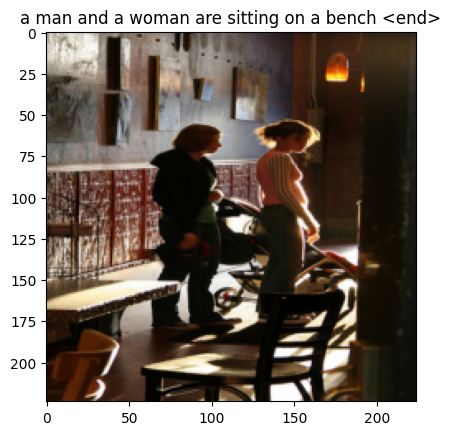

Epoch: 5 Training batch: 100 loss: 2.80703
Epoch: 5 Training batch: 200 loss: 2.83321
Epoch: 5 Training batch: 300 loss: 2.56126
Epoch: 5 Training batch: 400 loss: 2.70202
Epoch: 5 Training batch: 500 loss: 2.78764
Epoch: 5 Training batch: 600 loss: 2.90820
Epoch: 5 Training batch: 700 loss: 2.87585
Epoch: 5 Training batch: 800 loss: 2.67697
Epoch 5:
Average Training Loss: 2.77306
Validation Loss: 3.16378
METEOR Score: 0.21222


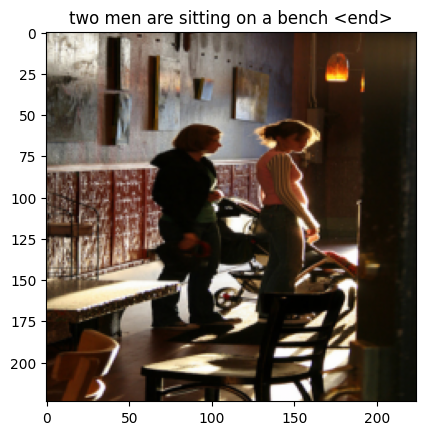

Epoch: 6 Training batch: 100 loss: 2.71123
Epoch: 6 Training batch: 200 loss: 2.62737
Epoch: 6 Training batch: 300 loss: 2.58383
Epoch: 6 Training batch: 400 loss: 2.33866
Epoch: 6 Training batch: 500 loss: 2.84267
Epoch: 6 Training batch: 600 loss: 2.59794
Epoch: 6 Training batch: 700 loss: 2.69004
Epoch: 6 Training batch: 800 loss: 2.68050
Epoch 6:
Average Training Loss: 2.61417
Validation Loss: 3.14412
METEOR Score: 0.21736


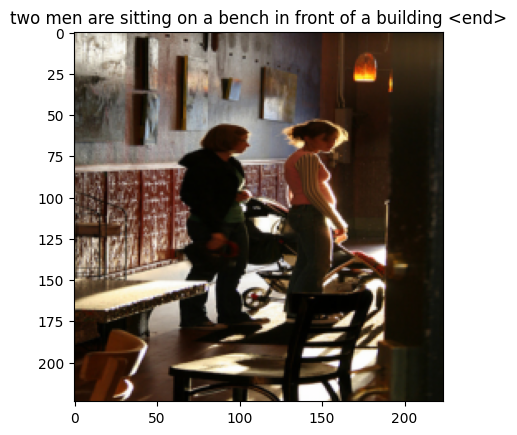

Epoch: 7 Training batch: 100 loss: 2.24288
Epoch: 7 Training batch: 200 loss: 2.40121
Epoch: 7 Training batch: 300 loss: 2.38063
Epoch: 7 Training batch: 400 loss: 2.48039
Epoch: 7 Training batch: 500 loss: 2.52606
Epoch: 7 Training batch: 600 loss: 2.54580
Epoch: 7 Training batch: 700 loss: 2.59708
Epoch: 7 Training batch: 800 loss: 2.51478
Epoch 7:
Average Training Loss: 2.46973
Validation Loss: 3.14376
METEOR Score: 0.21366


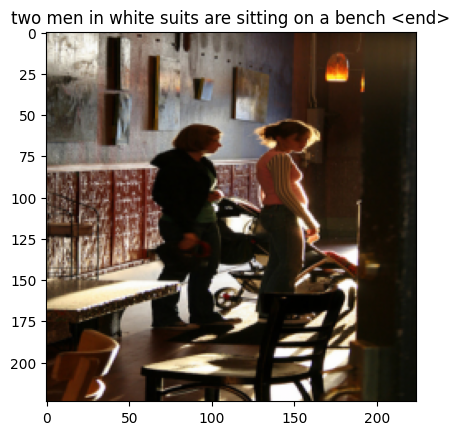

Epoch: 8 Training batch: 100 loss: 2.48348
Epoch: 8 Training batch: 200 loss: 2.23638
Epoch: 8 Training batch: 300 loss: 2.50305
Epoch: 8 Training batch: 400 loss: 2.48042
Epoch: 8 Training batch: 500 loss: 2.55763
Epoch: 8 Training batch: 600 loss: 2.50468
Epoch: 8 Training batch: 700 loss: 2.26073
Epoch: 8 Training batch: 800 loss: 2.58261
Epoch 8:
Average Training Loss: 2.33768
Validation Loss: 3.14631
METEOR Score: 0.21674


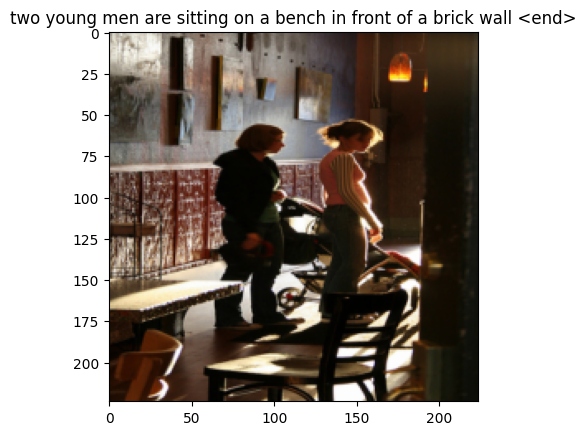

Epoch: 9 Training batch: 100 loss: 2.11630
Epoch: 9 Training batch: 200 loss: 2.38005
Epoch: 9 Training batch: 300 loss: 2.27713
Epoch: 9 Training batch: 400 loss: 2.15367
Epoch: 9 Training batch: 500 loss: 2.11477
Epoch: 9 Training batch: 600 loss: 2.11475
Epoch: 9 Training batch: 700 loss: 2.31341
Epoch: 9 Training batch: 800 loss: 2.46432
Epoch 9:
Average Training Loss: 2.21662
Validation Loss: 3.15451
METEOR Score: 0.21852


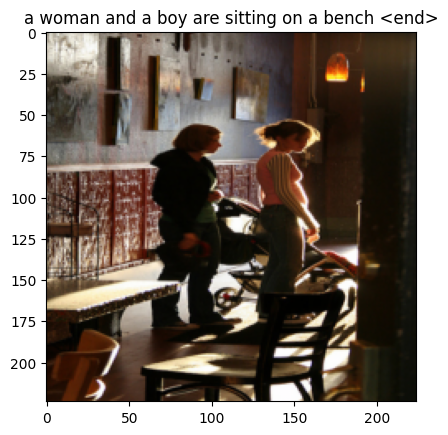

Epoch: 10 Training batch: 100 loss: 1.98332
Epoch: 10 Training batch: 200 loss: 2.21063
Epoch: 10 Training batch: 300 loss: 2.28315
Epoch: 10 Training batch: 400 loss: 2.01623
Epoch: 10 Training batch: 500 loss: 2.19590
Epoch: 10 Training batch: 600 loss: 1.99310
Epoch: 10 Training batch: 700 loss: 2.18371
Epoch: 10 Training batch: 800 loss: 2.19822
Epoch 10:
Average Training Loss: 2.10065
Validation Loss: 3.17150
METEOR Score: 0.22297


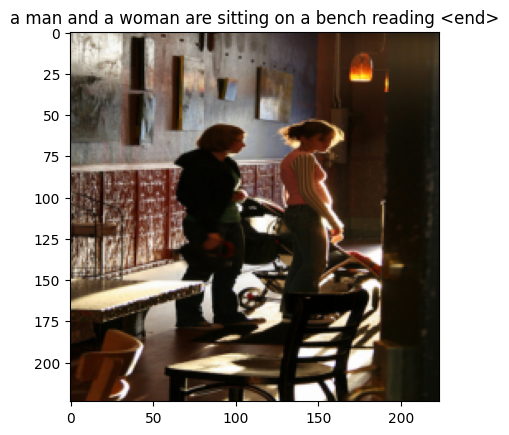

In [45]:
num_epochs = 10
print_every = 100
patience = 3
best_meteor = 0  # Changed from best_bleu
patience_counter = 0
train_losses = []
val_losses = []
val_meteors = []  # Changed from val_bleus

# Keep track of best model
best_model_state = None

for epoch in range(1, num_epochs+1):
    # Training phase
    model.train()
    epoch_train_loss = 0
    batch_count = 0
    
    for idx, (image, captions,_) in enumerate(train_loader):
        image, captions = image.to(device), captions.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Feed forward
        outputs, attentions = model(image, captions)
        
        # Calculate the batch loss
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        epoch_train_loss += loss.item()
        batch_count += 1
        
        if (idx+1) % print_every == 0:
            print(f"Epoch: {epoch} Training batch: {idx+1} loss: {loss.item():.5f}")
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / batch_count
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    batch_count = 0
    actual_captions = []
    predicted_captions = []
    
    with torch.no_grad():
        for val_images, val_captions,_ in val_loader:
            val_images = val_images.to(device)
            val_captions = val_captions.to(device)
            
            # Get model predictions
            outputs, _ = model(val_images, val_captions)
            targets = val_captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            
            val_loss += loss.item()
            batch_count += 1
            
            # Generate captions for METEOR score calculation
            features = model.module.encoder(val_images) if hasattr(model, 'module') else model.encoder(val_images)
            for i in range(val_images.size(0)):
                # Get actual caption (excluding start and end tokens)
                current_caption = val_captions[i].cpu().numpy().tolist()
                actual = [idx2word[word] for word in current_caption if word != word2idx['<start>'] 
                          and word != word2idx['<end>'] and word != word2idx['<pad>']]
                actual_captions.append(actual)
                
                # Generate predicted caption
                if hasattr(model, 'module'):
                    caps, _ = model.module.decoder.generate_caption(features[i:i+1])
                else:
                    caps, _ = model.decoder.generate_caption(features[i:i+1])
                predicted_captions.append(caps[:-1])  # exclude end token
    
    # Calculate average validation loss and METEOR score
    avg_val_loss = val_loss / batch_count
    val_losses.append(avg_val_loss)
    
    # Calculate METEOR score
    meteor_score_val = 0
    for ref, hyp in zip(actual_captions, predicted_captions):
        # METEOR expects a list of references for each hypothesis
        meteor_score_val += meteor_score([ref], hyp)
    meteor_score_val /= len(actual_captions)
    val_meteors.append(meteor_score_val)
    
    print(f"Epoch {epoch}:")
    print(f"Average Training Loss: {avg_train_loss:.5f}")
    print(f"Validation Loss: {avg_val_loss:.5f}")
    print(f"METEOR Score: {meteor_score_val:.5f}")
    
    # Example validation image caption generation
    dataiter = iter(val_loader)
    img,_,_ = next(dataiter)
    if hasattr(model, 'module'):
        features = model.module.encoder(img[0:1].to(device))
        caps, alphas = model.module.decoder.generate_caption(features)
    else:
        features = model.encoder(img[0:1].to(device))
        caps, alphas = model.decoder.generate_caption(features)
    caption = ' '.join(caps)
    show_image(img[0], title=caption)
    
    # Early stopping check
    if meteor_score_val > best_meteor:  # Changed from best_bleu
        best_meteor = meteor_score_val  # Changed from best_bleu
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        save_model(model, epoch)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch}")
            # Restore best model
            model.load_state_dict(best_model_state)
            break

# Save final metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_meteors': val_meteors,  # Changed from val_bleus
    'best_meteor': best_meteor  # Changed from best_bleu
}

torch.save(metrics, 'training_metrics.pt')

# Loss and Metor Score Plots

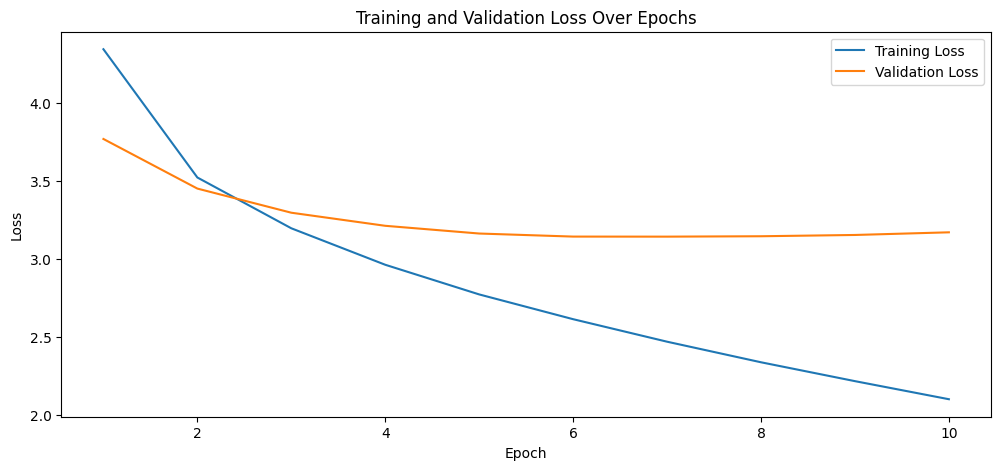

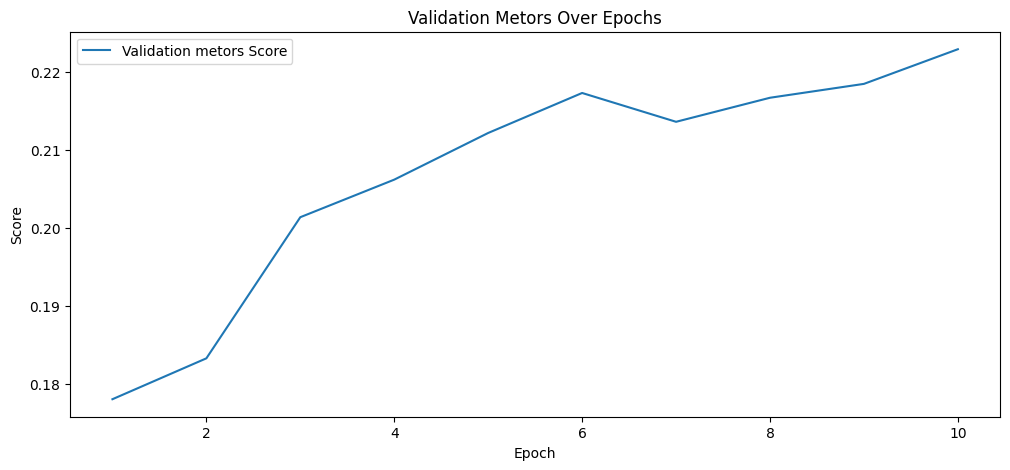

In [47]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.plot(epochs, metrics["train_losses"], label='Training Loss')
plt.plot(epochs, metrics["val_losses"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting BLEU 
plt.figure(figsize=(12, 5))
plt.plot(epochs, metrics["val_meteors"], label='Validation metors Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metors Over Epochs')
plt.legend()
plt.show()


# Demo on The test set

In [48]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

In [49]:
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(28,28)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

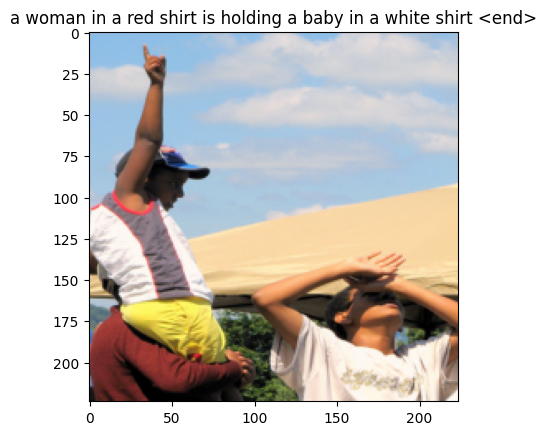

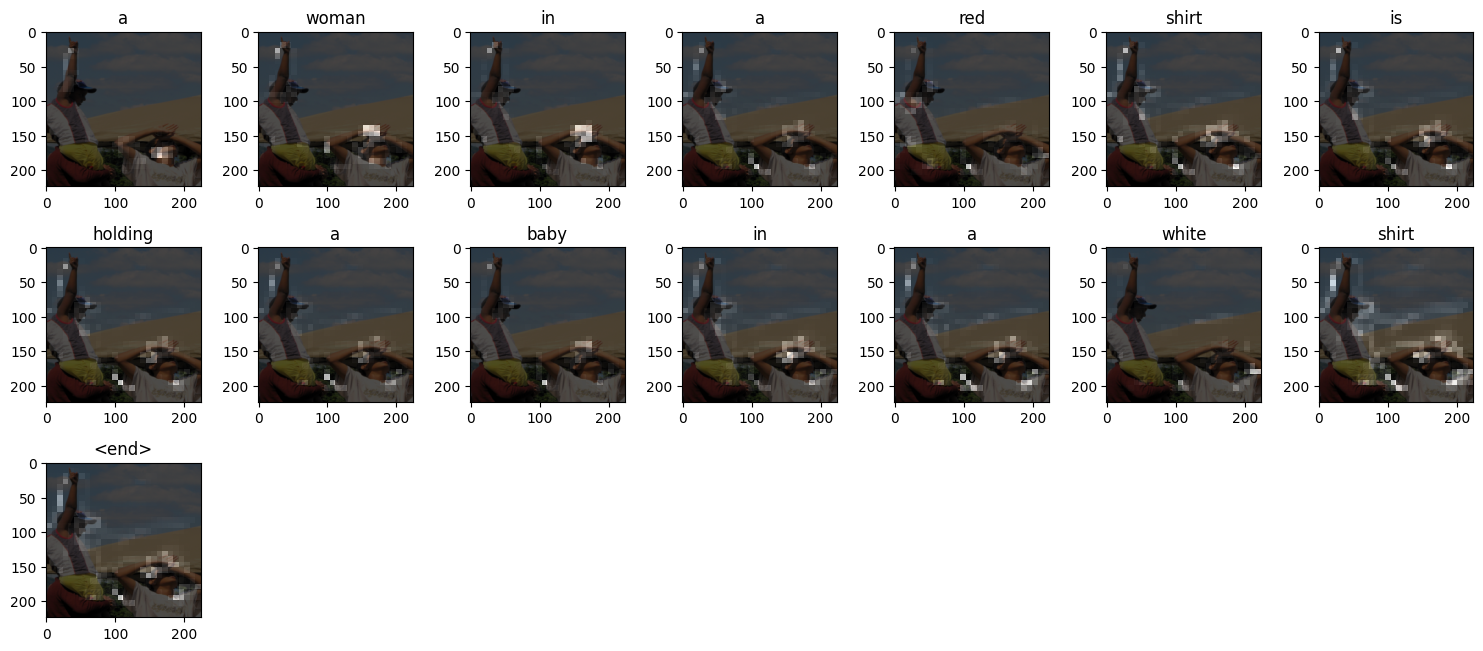

In [50]:
# Get a specific index from test dataset
idx = 5  # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

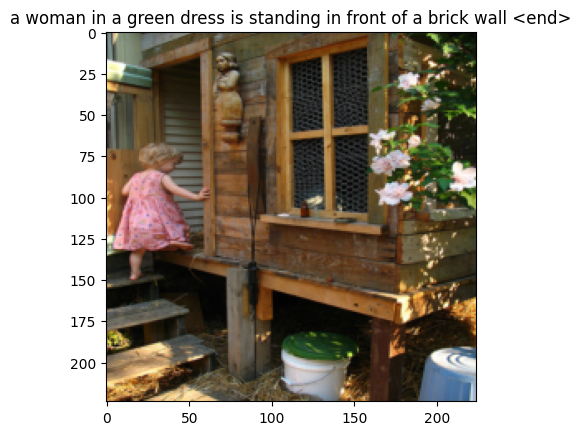

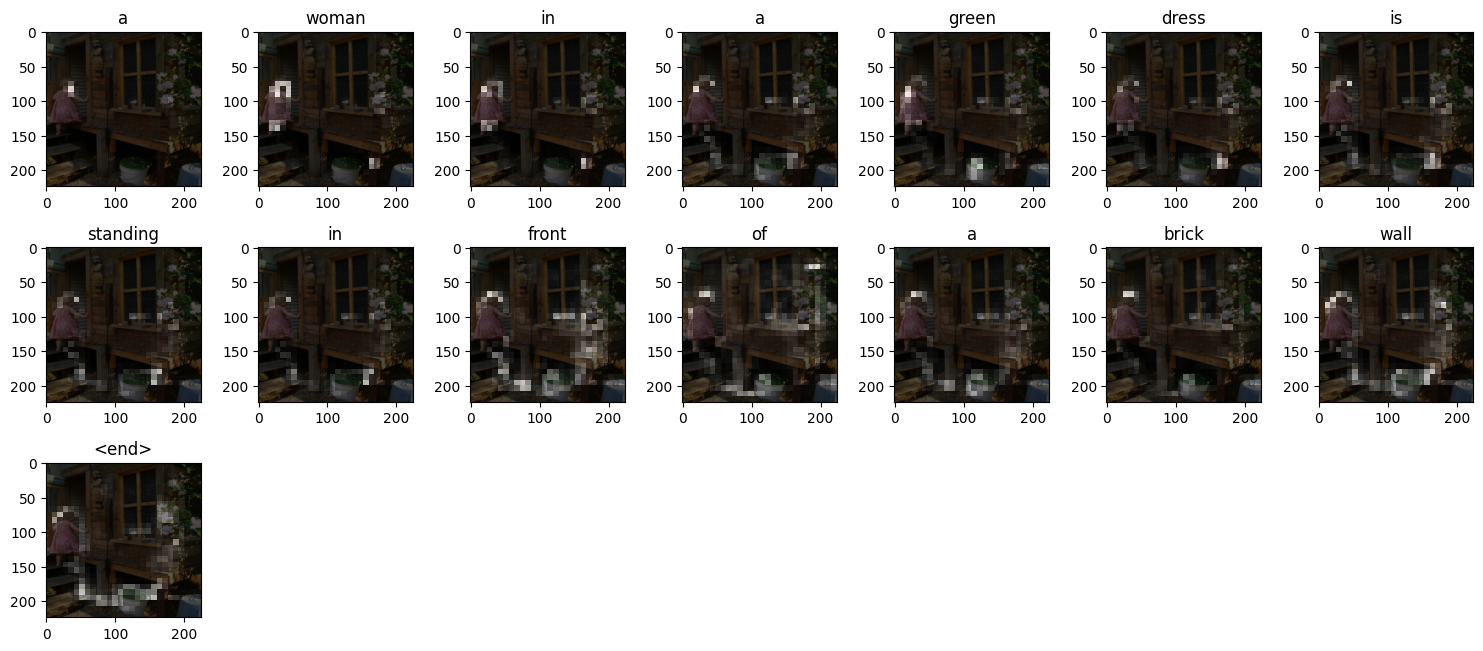

In [51]:
# Get a specific index from test dataset
idx = 100  # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

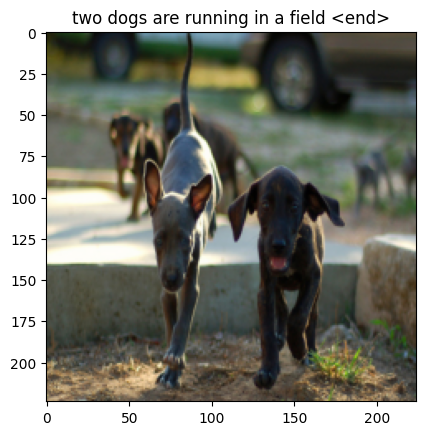

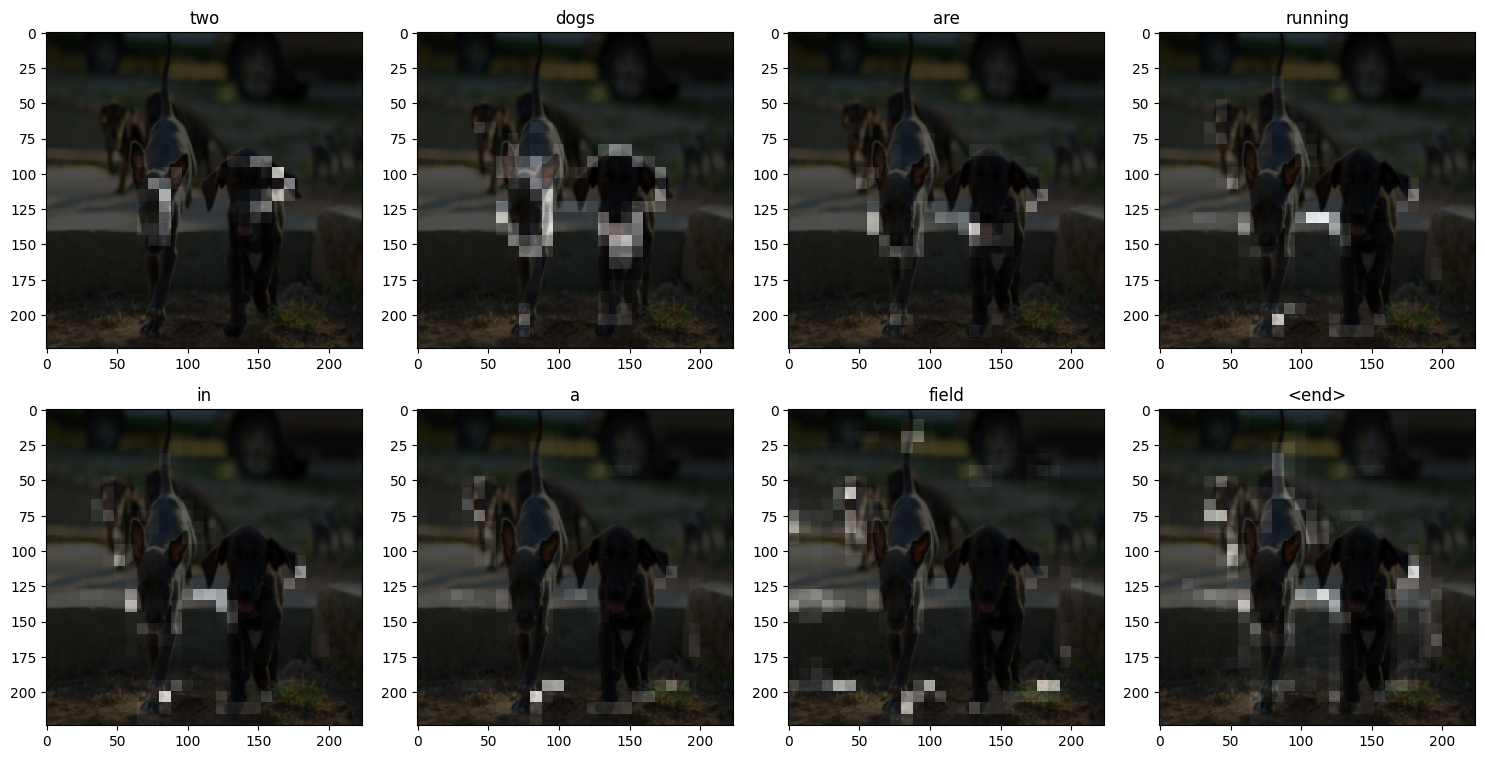

In [52]:
# Get a specific index from test dataset
idx = 145  # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

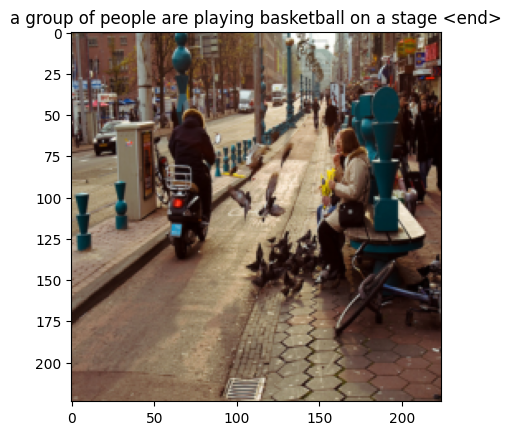

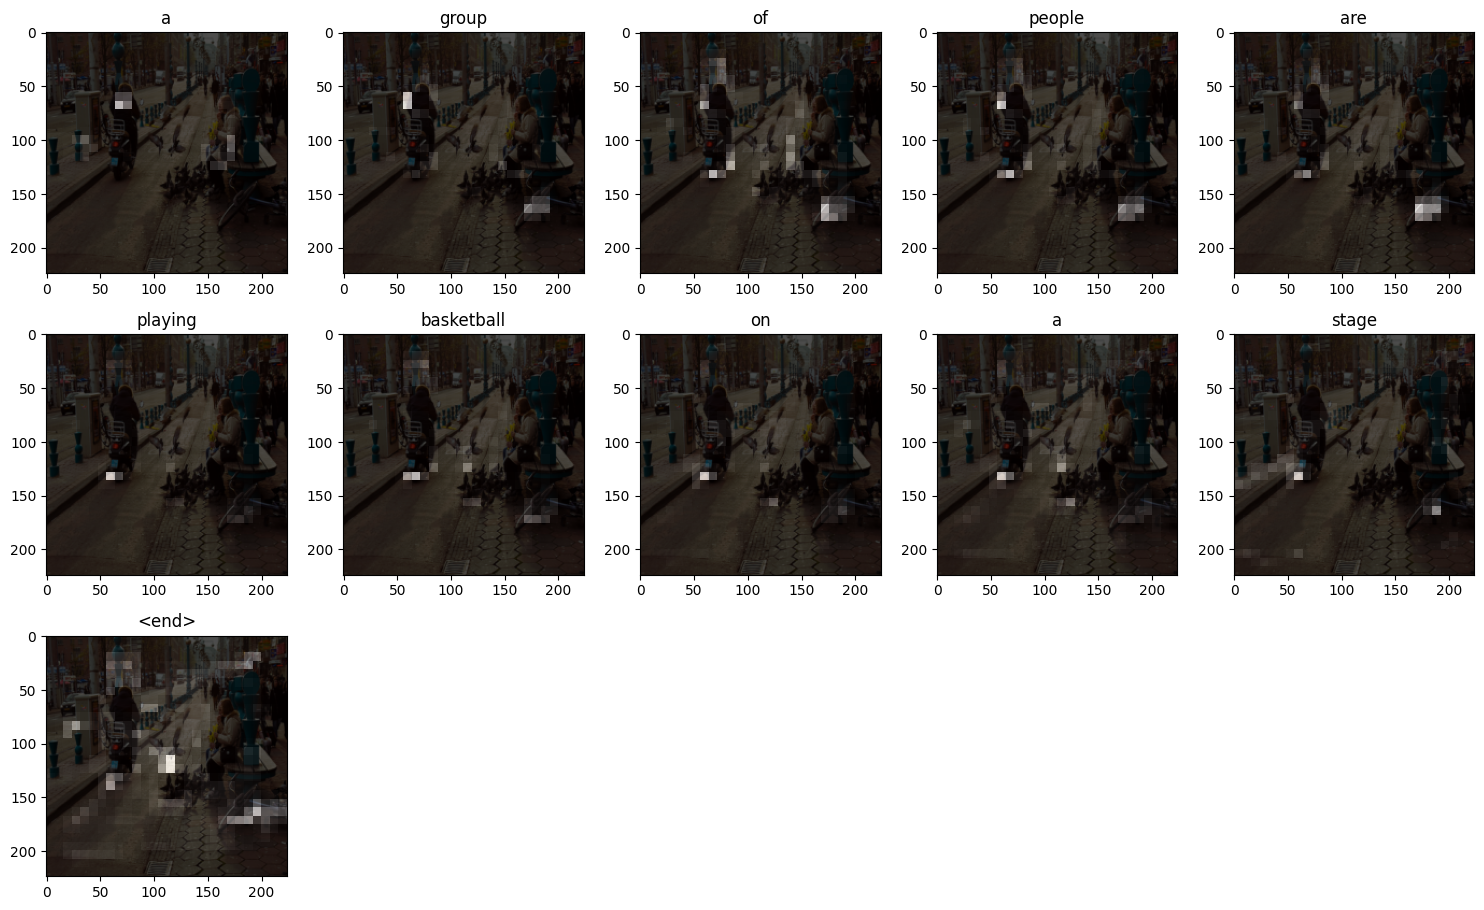

In [53]:
# Get a specific index from test dataset
idx = 212 # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

# Metor score on Test dataset

In [58]:
def calculate_test_meteor():
    model.eval()  # Set to evaluation mode
    actual_captions = []
    predicted_captions = []
    
    with torch.no_grad():
        for test_images, test_captions, *_ in test_loader:
            test_images = test_images.to(device)
            
            # Generate captions for METEOR score calculation
            features = model.module.encoder(test_images) if hasattr(model, 'module') else model.encoder(test_images)
            
            for i in range(test_images.size(0)):
                # Get actual caption (excluding special tokens)
                current_caption = test_captions[i].cpu().numpy().tolist()
                actual = [idx2word[word] for word in current_caption if word != word2idx['<start>']
                         and word != word2idx['<end>'] and word != word2idx['<pad>']]
                actual_captions.append(actual)
                
                # Generate predicted caption
                if hasattr(model, 'module'):
                    caps, *_ = model.module.decoder.generate_caption(features[i:i+1])
                else:
                    caps, *_ = model.decoder.generate_caption(features[i:i+1])
                predicted_captions.append(caps[:-1])  # exclude end token
    
    # Calculate METEOR score
    meteor_score_val = 0
    for ref, hyp in zip(actual_captions, predicted_captions):
        # METEOR expects a list of references for each hypothesis
        meteor_score_val += meteor_score([ref], hyp)
    meteor_score_val /= len(actual_captions)
    
    print(f"Test METEOR Score: {meteor_score_val:.4f}")
    return meteor_score_val

# Calculate METEOR score on test set
test_meteor = calculate_test_meteor()

Test METEOR Score: 0.2231
